# Librearías externas


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../src/')
from ai_utec import gradient_descent 
from ai_utec import utility

# Carga, verificación y limpieza de datos

In [2]:
url = "https://raw.githubusercontent.com/nutax/ai-pro1-files/main/forestfires.csv"
df = pd.read_csv(url)

In [3]:
df.shape

(517, 13)

In [4]:
df.isna().sum().sort_values()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

# Análisis descriptivo

## Distribución del OUTPUT: AREA

#### Información general

In [5]:
df['area'].describe()

count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64

#### Existen dos grandes grupos: se incendia y no se incendia

Text(0.5, 1.0, 'Distribución del área')

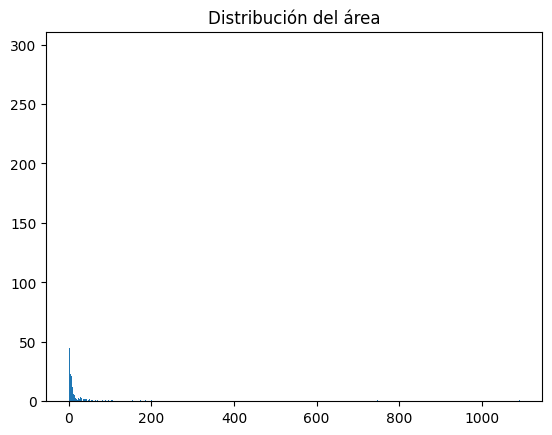

In [6]:
_ = plt.hist(df['area'], bins='auto')
plt.title('Distribución del área')

In [7]:
area = df['area'].to_numpy()
area[area == 0].shape[0] / area.shape[0]

0.47775628626692457

In [8]:
dfa = df.drop(df[df.area == 0].index, inplace=False)

In [9]:
dfs = df.drop(df[df.area > 0].index, inplace=False)

#### El área parece seguir una función exponencial

Text(0.5, 1.0, 'Distribución del área incendiada')

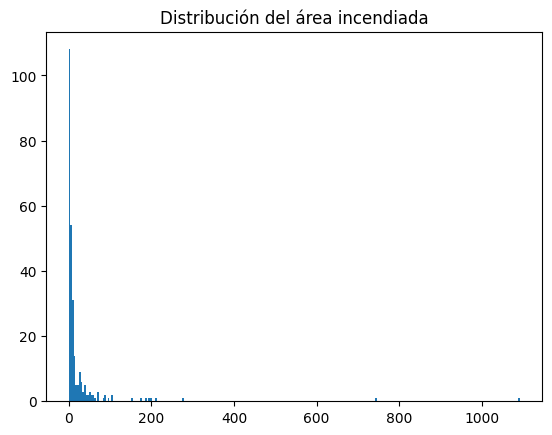

In [10]:
_ = plt.hist(dfa['area'], bins='auto')
plt.title('Distribución del área incendiada')

#### El exponente parece seguir una distribución normal

Text(0.5, 1.0, 'Distribución de log(área incendiada)')

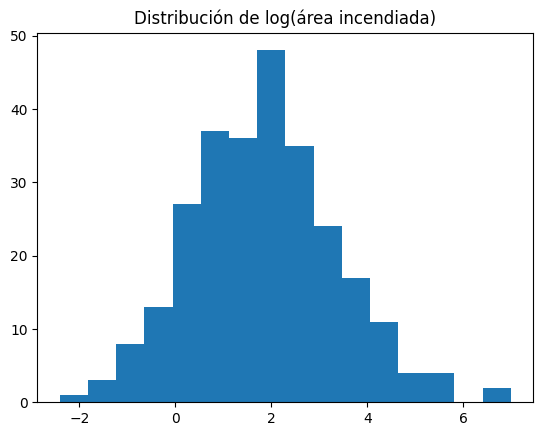

In [11]:
dfa['exp'] = np.log(dfa['area'])
_ = plt.hist(dfa['exp'], bins='auto')
plt.title('Distribución de log(área incendiada)')

In [12]:
dfa['exp'].describe()

count    270.000000
mean       1.844831
std        1.526712
min       -2.407946
25%        0.760806
50%        1.851598
75%        2.735823
max        6.994703
Name: exp, dtype: float64

#### Existen datos muy atípicos

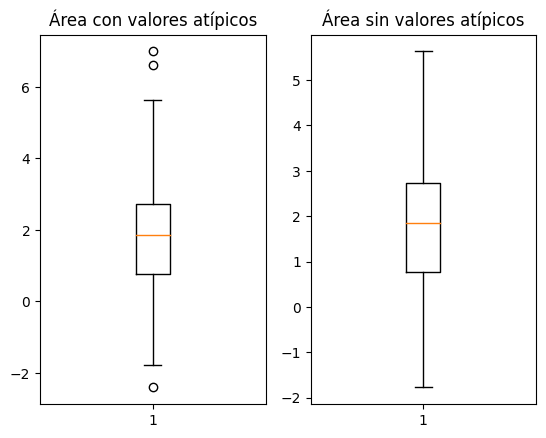

In [13]:
fig1, ax1 = plt.subplots(nrows=1, ncols=2)
ax1 = ax1.flat
ax1[0].set_title('Área con valores atípicos')
ax1[1].set_title('Área sin valores atípicos')
box_con_atipicos = ax1[0].boxplot(dfa['exp'])
box_sin_atipicos = ax1[1].boxplot(dfa['exp'], showfliers=False)

In [14]:
outliers = np.abs(dfa.exp - dfa.exp.mean() > dfa.exp.std())
np.array(sorted(dfa.exp[outliers]))

array([3.38371207, 3.40717945, 3.41180756, 3.4569474 , 3.4613513 ,
       3.46792101, 3.5368931 , 3.58018004, 3.60685562, 3.61145831,
       3.62992531, 3.65013863, 3.67249597, 3.70228914, 3.75817228,
       3.76861442, 3.84374416, 3.88259419, 3.89934295, 3.9037892 ,
       3.94700397, 3.99434005, 4.02606572, 4.06560209, 4.11300274,
       4.16044436, 4.25305625, 4.25929387, 4.26689633, 4.41582401,
       4.45956621, 4.48288955, 4.55576984, 4.63850825, 4.66022639,
       5.04265062, 5.16266945, 5.22445552, 5.28056064, 5.30300636,
       5.36072863, 5.62952577, 6.61510086, 6.99470332])

In [15]:
dfan = dfa.drop(dfa[np.abs(dfa.exp) > (dfa.exp.mean() + dfa.exp.std())].index, inplace=False) 

## Distribución de INPUT

#### Distribución de las variables numéricas

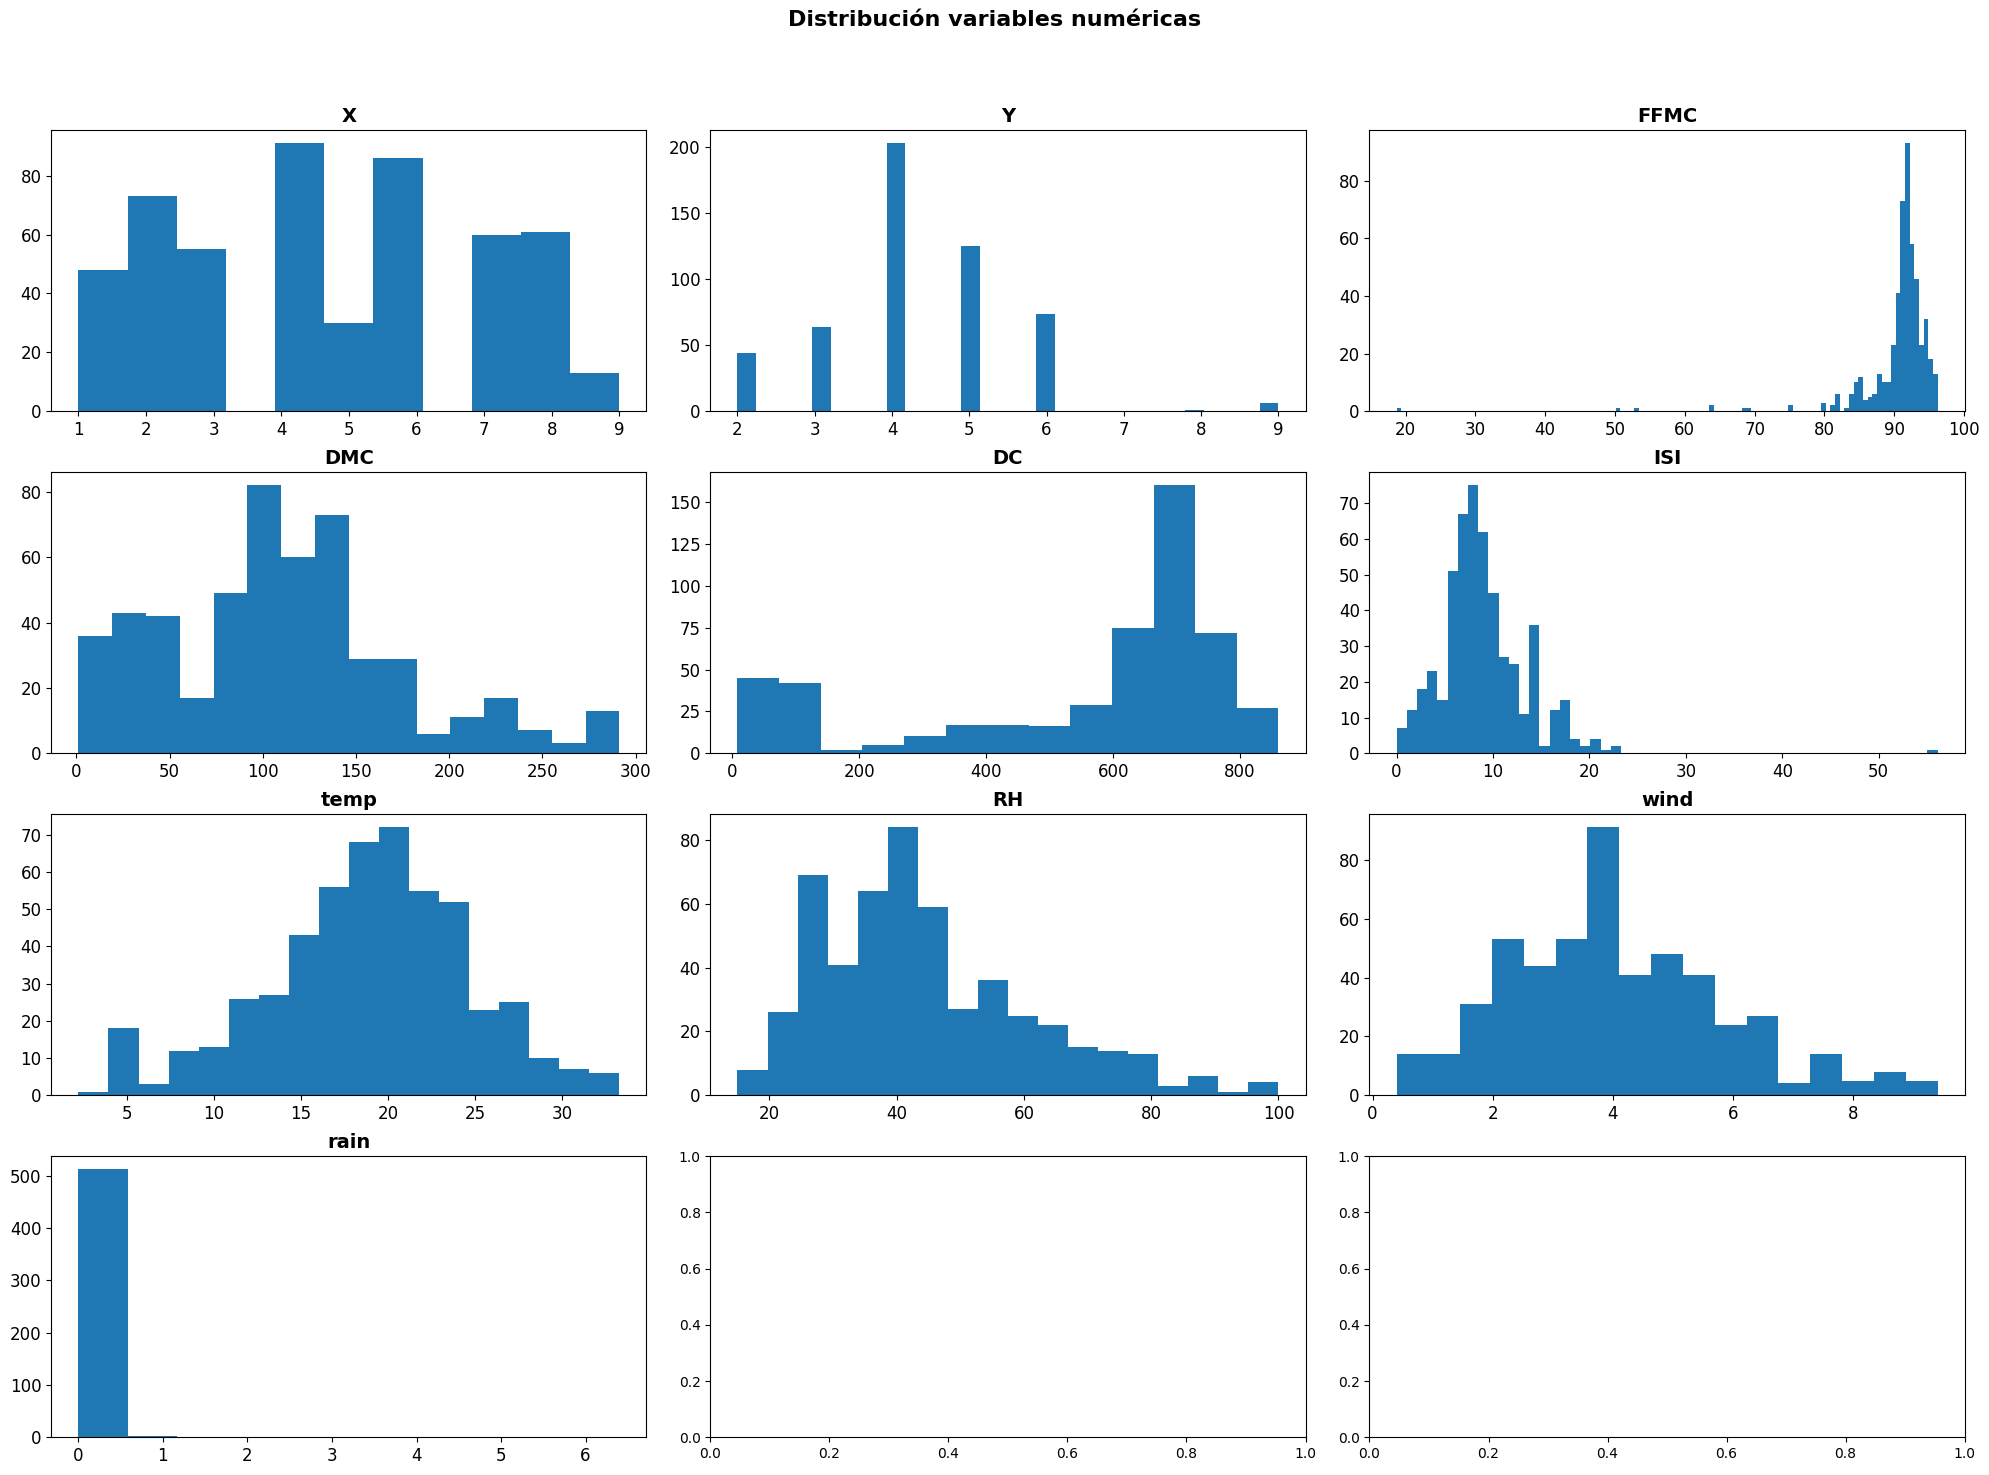

In [16]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
axes = axes.flat
columnas_numeric = df.select_dtypes(include=['float', 'int']).columns
columnas_numeric = columnas_numeric.drop('area')

for i, colum in enumerate(columnas_numeric):
    axes[i].hist(df[colum], bins='auto')
    axes[i].set_title(colum, fontsize = 14, fontweight = "bold")
    axes[i].tick_params(labelsize = 12)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 16, fontweight = "bold");

#### Distribución de las variables categóricas

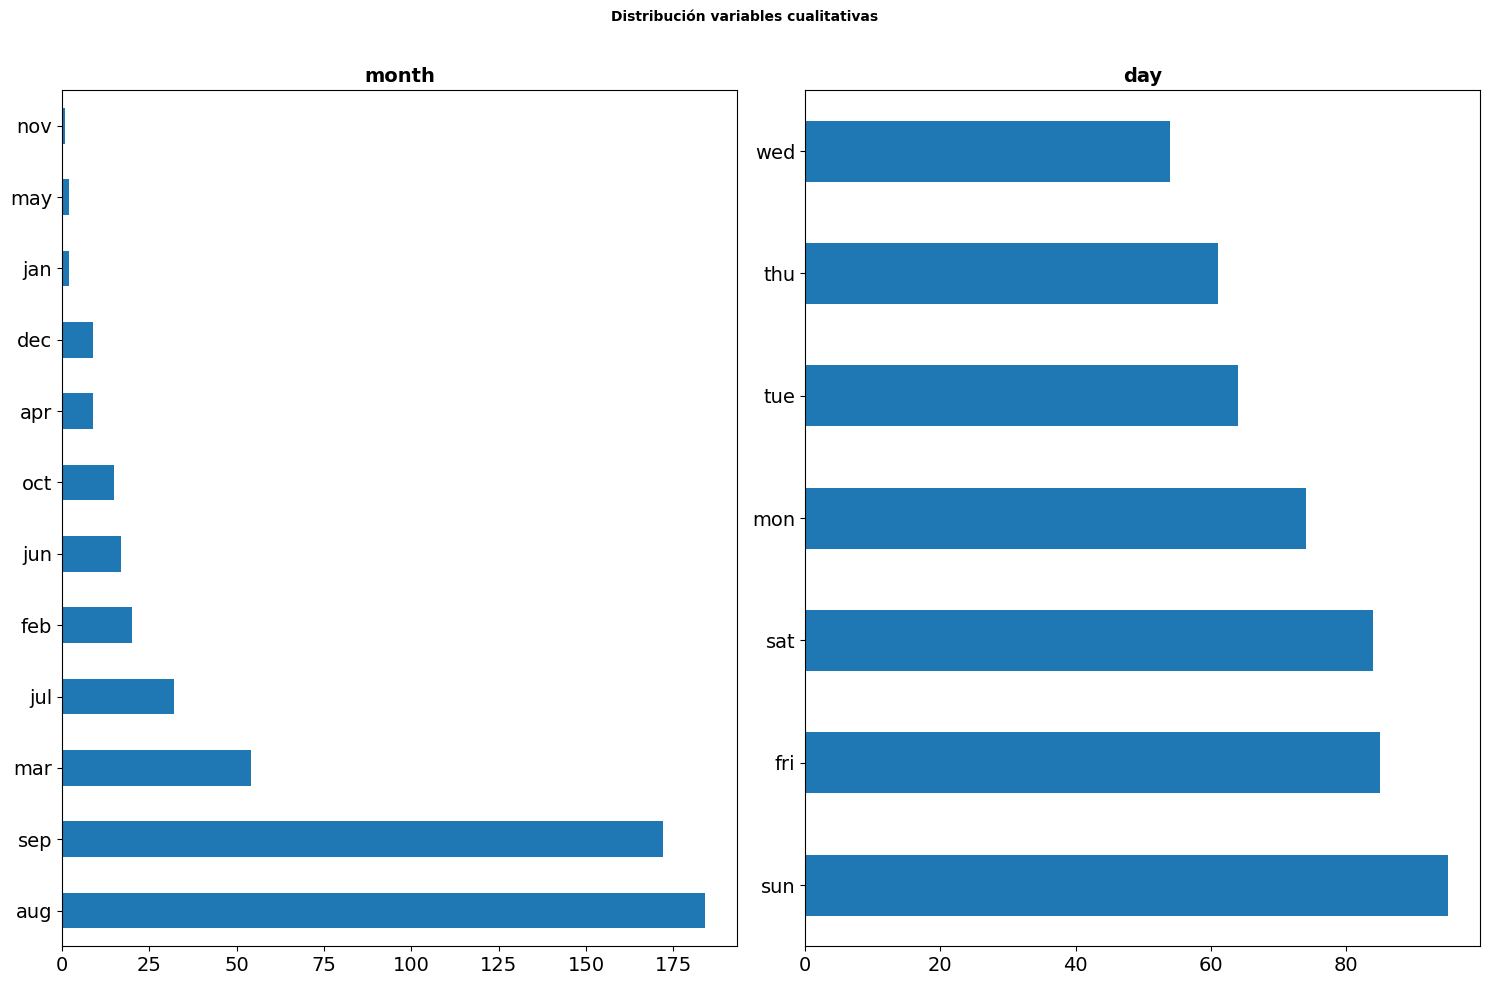

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
axes = axes.flat
columnas_object = df.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    df[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 14, fontweight = "bold")
    axes[i].tick_params(labelsize = 14)
    axes[i].set_xlabel("")

    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables cualitativas',
             fontsize = 10, fontweight = "bold");

# Análisis inferencial

#### No existen altas correlaciones individuales (Regresión lineal simple)

In [18]:
df.corr()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
X,1.000000,0.539548,-0.021039,-0.048384,-0.085916,0.006210,-0.051258,0.085223,0.018798,0.065387,0.063385
Y,0.539548,1.000000,-0.046308,0.007782,-0.101178,-0.024488,-0.024103,0.062221,-0.020341,0.033234,0.044873
FFMC,-0.021039,-0.046308,1.000000,0.382619,0.330512,0.531805,0.431532,-0.300995,-0.028485,0.056702,0.040122
DMC,-0.048384,0.007782,0.382619,1.000000,0.682192,0.305128,0.469594,0.073795,-0.105342,0.074790,0.072994
DC,-0.085916,-0.101178,0.330512,0.682192,1.000000,0.229154,0.496208,-0.039192,-0.203466,0.035861,0.049383
ISI,0.006210,-0.024488,0.531805,0.305128,0.229154,1.000000,0.394287,-0.132517,0.106826,0.067668,0.008258
temp,-0.051258,-0.024103,0.431532,0.469594,0.496208,0.394287,1.000000,-0.527390,-0.227116,0.069491,0.097844
RH,0.085223,0.062221,-0.300995,0.073795,-0.039192,-0.132517,-0.527390,1.000000,0.069410,0.099751,-0.075519
wind,0.018798,-0.020341,-0.028485,-0.105342,-0.203466,0.106826,-0.227116,0.069410,1.000000,0.061119,0.012317
rain,0.065387,0.033234,0.056702,0.074790,0.035861,0.067668,0.069491,0.099751,0.061119,1.000000,-0.007366


#### No existen diferencias evidentes entre grupo que se incendia poco, medio y mucho

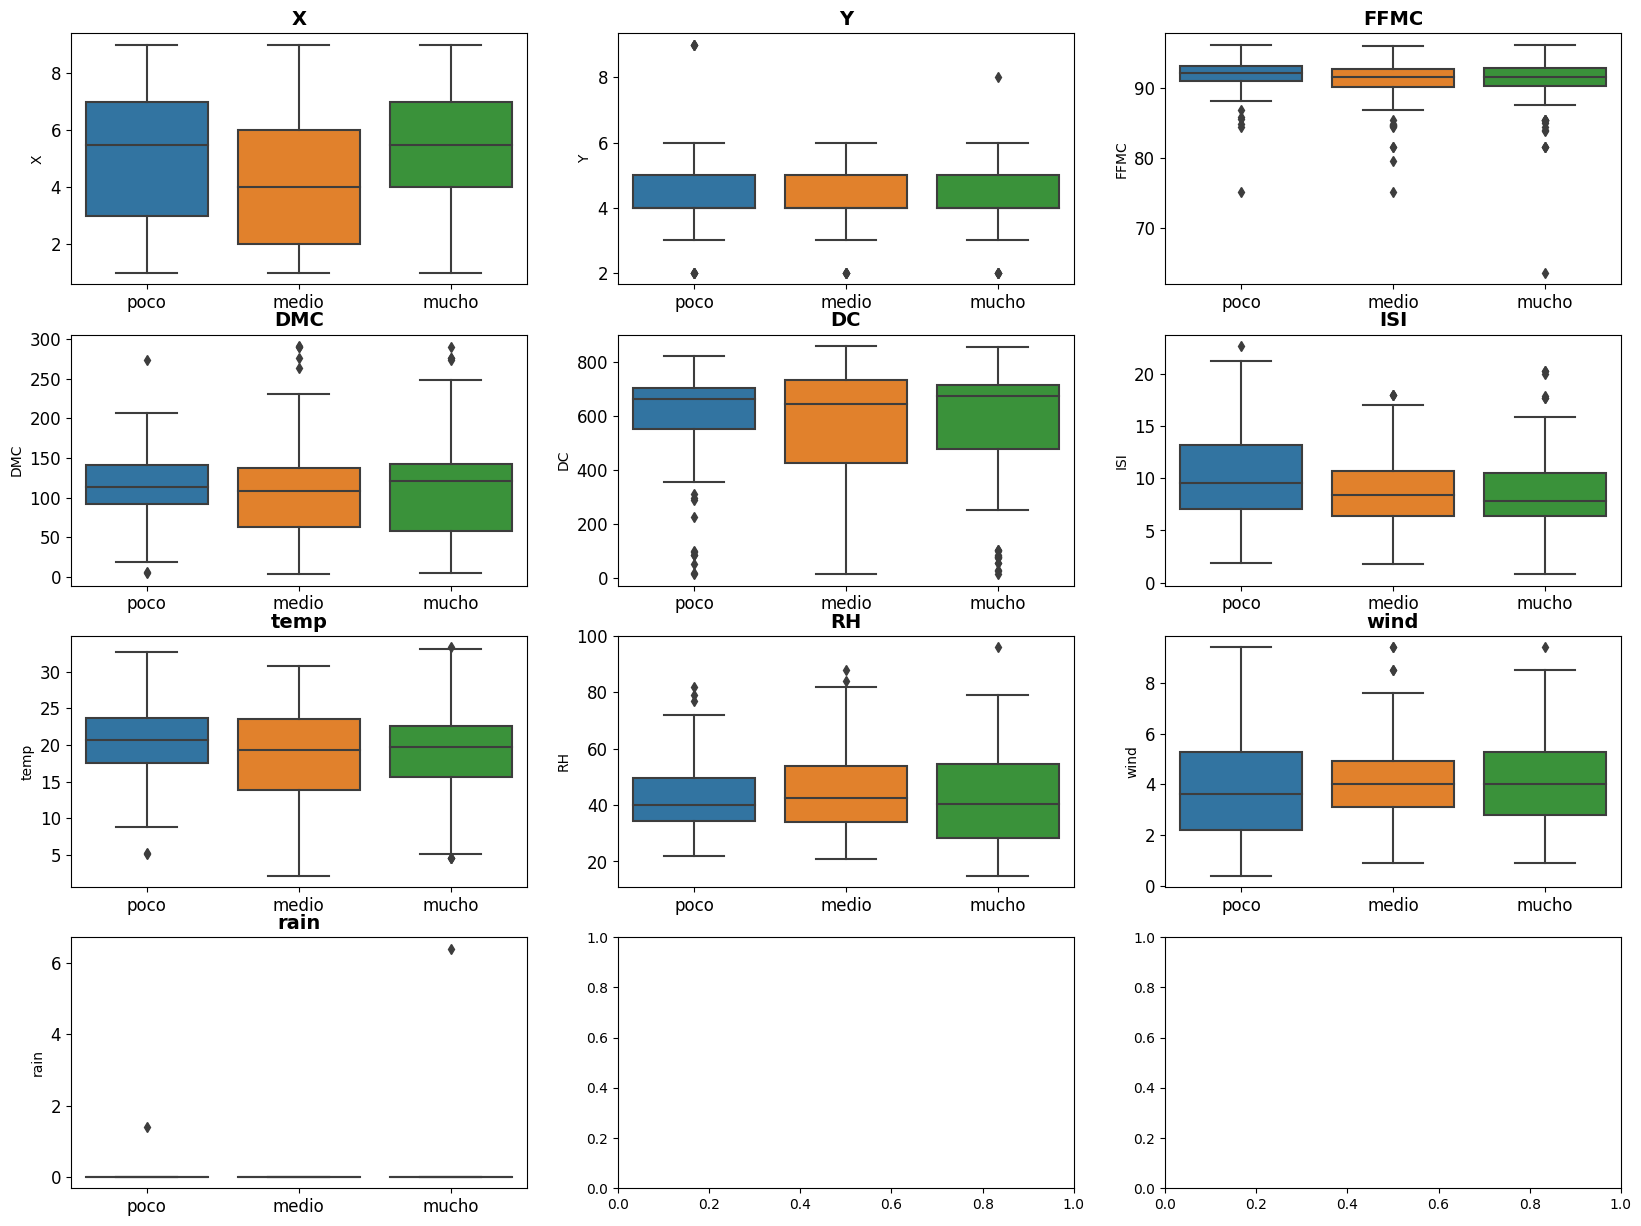

In [19]:
dfa['area_cat'] = pd.qcut(dfa.area, q=3,
                        labels=['poco',
                                'medio',
                                'mucho'])
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
axes = axes.flat
columnas_numeric = dfa.select_dtypes(include=['float', 'int']).columns
columnas_numeric = columnas_numeric.drop(['area','exp'])

for i, colum in enumerate(columnas_numeric):
    sns.boxplot(data=dfa, x='area_cat', y=colum, ax=axes[i])
    axes[i].set_title(colum, fontsize = 14, fontweight = "bold")
    axes[i].tick_params(labelsize = 12)
    axes[i].set_xlabel("")

#### Regresión lineal múltiple funciona parcialmente

##### Entrenamiento y Pruebas

MSE
r squared: 0.07243972771528014
MAE
r squared: 0.08309739656897813
RMSE
r squared: 0.07853115399789357


(-1.0, 1.0)

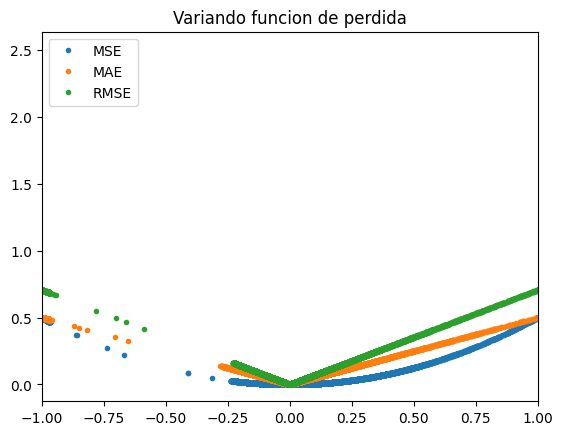

In [20]:
# dfa = dfa[dfa.area < 20.0]s
x = (dfa[["temp","RH","wind","rain"]]).to_numpy()
y = (dfa[["area"]]).to_numpy()
xTr, yTr, xV, yV, xT, yT = utility.classic_split(x, y)

# print(xTr.shape)
# print(yTr.shape)
# print(xV.shape)
# print(yV.shape)
# print(xT.shape)
# print(xT.shape)

w, predict, lossT, lossV, dw = gradient_descent.train(xTr, yTr, xV, yV, epochs=100000, alpha=0.001, norm_f=utility.norm, 
    denorm_f=utility.denorm, extra_f = utility.add_bias,
                                                          winit_f = utility.random_weights,
                                                          hypo_f = utility.weighted_sum,
                                                          diff_f = utility.difference,
                                                          loss_f = utility.lm_loss_mse,
                                                          delta_f = utility.lm_delta,
                                                          update_f = utility.substract_delta,
                                                          batch_f = utility.random_batch_gen(1))
# print(w)
print("MSE")
plt.plot(dw, lossT, ".", label = "MSE")
print("r squared: {}".format(utility.r_squared(yTr, predict(xTr))))


w, predict, lossT, lossV, dw = gradient_descent.train(xTr, yTr, xV, yV, epochs=100000, alpha=0.001, norm_f=utility.norm, 
    denorm_f=utility.denorm, extra_f = utility.add_bias,
                                                          winit_f = utility.random_weights,
                                                          hypo_f = utility.weighted_sum,
                                                          diff_f = utility.difference,
                                                          loss_f = utility.lm_loss_mae,
                                                          delta_f = utility.lm_delta,
                                                          update_f = utility.substract_delta,
                                                          batch_f = utility.random_batch_gen(1))

print("MAE")
plt.plot(dw, lossT, ".", label = "MAE")
print("r squared: {}".format(utility.r_squared(yTr, predict(xTr))))

w, predict, lossT, lossV, dw = gradient_descent.train(xTr, yTr, xV, yV, epochs=100000, alpha=0.001, norm_f=utility.norm, 
    denorm_f=utility.denorm, extra_f = utility.add_bias,
                                                          winit_f = utility.random_weights,
                                                          hypo_f = utility.weighted_sum,
                                                          diff_f = utility.difference,
                                                          loss_f = utility.lm_loss_rmse,
                                                          delta_f = utility.lm_delta,
                                                          update_f = utility.substract_delta,
                                                          batch_f = utility.random_batch_gen(1))

print("RMSE")
plt.plot(dw, lossT, ".", label = "RMSE")
print("r squared: {}".format(utility.r_squared(yTr, predict(xTr))))

plt.title("Variando funcion de perdida")
plt.legend(loc="upper left")
plt.xlim(-1, 1.0)

##### Gráficos de mejoras según hiperparámetro

C:\Users\lucho\AppData\Local\Temp\ipykernel_19180\3758679654.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes.plot([yT.min(), yT.max()], [yT.min(), yT.max()],


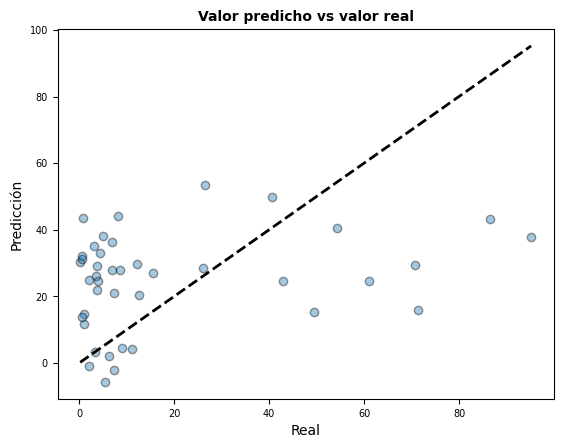

In [21]:
fig, axes = plt.subplots()

axes.scatter(yT, predict(xT), edgecolors=(0, 0, 0), alpha = 0.4)
axes.plot([yT.min(), yT.max()], [yT.min(), yT.max()],
                'k--', color = 'black', lw=2)
axes.set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes.set_xlabel('Real')
axes.set_ylabel('Predicción')
axes.tick_params(labelsize = 7)

#### Mejor regresión no lineal simple posible

##### Entrenamiento y Pruebas

In [22]:
poly = PolynomialFeatures(degree=5)
poly_variables = poly.fit_transform(x)

poly_var_train, poly_var_test, res_train, res_test = train_test_split(poly_variables, y, test_size = 0.3, random_state = 4)

regression = linear_model.LinearRegression()

model = regression.fit(poly_var_train, res_train)
score = model.score(poly_var_test, res_test)
print(score)

-16.484028847718804


C:\Users\lucho\AppData\Local\Temp\ipykernel_19180\624555962.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes.plot([res_test.min(), res_test.max()], [res_test.min(), res_test.max()],


(0.0, 100.0)

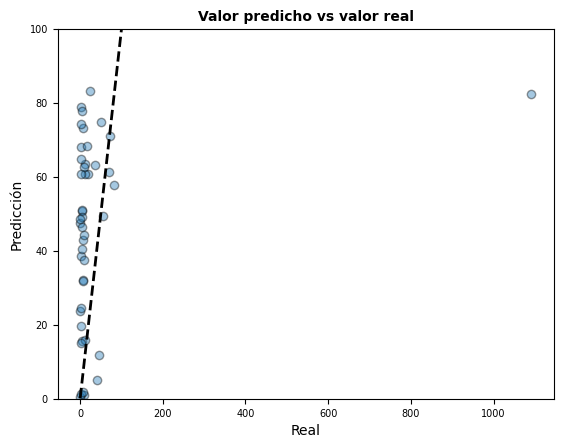

In [23]:
fig, axes = plt.subplots()

axes.scatter(res_test, model.predict(poly_var_test), edgecolors=(0, 0, 0), alpha = 0.4)
axes.plot([res_test.min(), res_test.max()], [res_test.min(), res_test.max()],
                'k--', color = 'black', lw=2)
axes.set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes.set_xlabel('Real')
axes.set_ylabel('Predicción')
axes.tick_params(labelsize = 7)
axes.set_ylim(0, 100)


In [24]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2, kernel='poly'))
regr.fit(xTr, yTr)

C:\Users\lucho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2, kernel='poly'))])

Gráficos de mejoras según hiperparámetro

C:\Users\lucho\AppData\Local\Temp\ipykernel_19180\1571473764.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes.plot([yT.min(), yT.max()], [yT.min(), yT.max()],


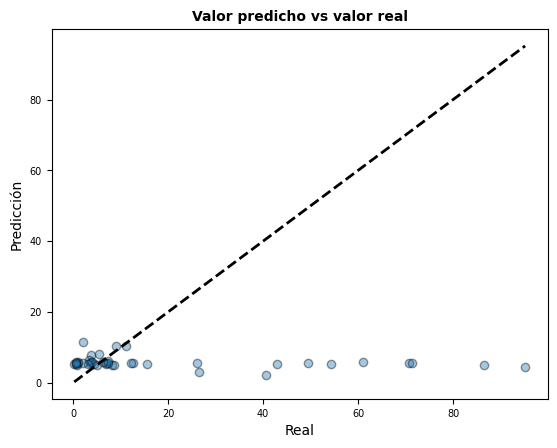

In [25]:
fig, axes = plt.subplots()

axes.scatter(yT, regr.predict(xT), edgecolors=(0, 0, 0), alpha = 0.4)
axes.plot([yT.min(), yT.max()], [yT.min(), yT.max()],
                'k--', color = 'black', lw=2)
axes.set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes.set_xlabel('Real')
axes.set_ylabel('Predicción')
axes.tick_params(labelsize = 7)

#### Regresion no lineal múltiple funciona parcialmente

##### Entrenamiento y Pruebas

##### Gráficos de mejoras según hiperparámetro